# Primary Time-step and Position Analysis

Determining a few parameters in relation to the raw data, namely: the average time-step, the average lattitude/longitude. These can then be used as to resample the data in the time domain and provide a sensible coordinate system.

## Time-step Analysis

In [16]:
%matplotlib inline

import csv, os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

thedir = '/Users/JBremner/Desktop/Beijing Trajectories/Geolife Trajectories 1.3/Data'

def meanTime(root, direc, labelState, traj): #returns mean time-step of trajectory

    df = pd.read_csv(root + '/' + direc + '/Trajectory/' + '/' + labelState + '/' + traj)
    dtBar = df.dayNo.diff().mean() * 86400 #average time-step in seconds
    return dtBar

def meanTimes(root): #returns array of mean time-steps of all trajectories

    dirs = [name for name in os.listdir(root) if os.path.isdir(os.path.join(root, name))]
    meanTimes = []
    
    for direc in dirs:
        trajdir = root + '/' + direc + '/Trajectory/'
        labelStates = [name for name in os.listdir(trajdir) if os.path.isdir(os.path.join(trajdir, name))]
        for labelState in labelStates:
            trajs = os.listdir(root + '/' + direc + '/Trajectory/' + labelState + '/')
            for traj in trajs:
                dtBar = meanTime(root, direc, labelState, traj)
                if not math.isnan(dtBar):
                    meanTimes.append(dtBar)
                
    return np.array(meanTimes)

meanTimes = meanTimes(thedir)
print('Filtered dataset contains:',len(meanTimes),'trajectories')

Filtered dataset contains: 21665 trajectories


A histogram of the mean time-steps (in the typical range):

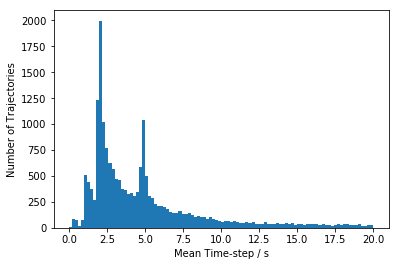

In [22]:
plt.hist(meanTimes, bins=100, range=[0,20])
plt.xlabel('Mean Time-step / s')
plt.ylabel('Number of Trajectories')
plt.show()

Some distribution statistics:

In [18]:
print('Max:', np.max(meanTimes),'s')
print('Min:', np.min(meanTimes),'s')
print('Mean:', np.mean(meanTimes),'s')
print('Median:', np.median(meanTimes),'s')
print('Standard Deviation:', np.std(meanTimes),'s')

Max: 14465.5000028 s
Min: 0.0 s
Mean: 20.384836371 s
Median: 4.48470209368 s
Standard Deviation: 198.204657622 s


Probably sensible to upsample the trajectories to a time-step close to the minimum step observed so as not to _lose_ resolution in any of the trajectories.

Have the option to use a simple linear interpolation but considering using polynomial or spline methods as these could give more natural trajectories without sharp edges. These may be suitable for larger space/time-steps, however most trajectories have sufficient sampling rate to simply use a linear interpolation (also given the size of the dataset).

## Position Analysis

In [25]:
def meanPos(root, direc, labelState, traj): #returns mean latitude/longitude coordinates from trajectory
    
    df = pd.read_csv(root + '/' + direc + '/Trajectory/' + labelState + '/' + traj)
    latMean = df.Lat.mean()
    longMean = df.Long.mean()
    return [latMean, longMean]

def meanPoss(root): #returns array of mean latitude/longitude coordinates from all trajectories

    dirs = [name for name in os.listdir(root) if os.path.isdir(os.path.join(root, name))]
    meanPoss = []
            
    for direc in dirs:
        trajdir = root + '/' + direc + '/Trajectory/'
        labelStates = [name for name in os.listdir(trajdir) if os.path.isdir(os.path.join(trajdir, name))]
        for labelState in labelStates:
            trajs = os.listdir(root + '/' + direc + '/Trajectory/' + labelState + '/')
            for traj in trajs:
                meanPoss.append(meanPos(root, direc, labelState, traj))

    return np.array(meanPoss)

meanPoss = meanPoss(thedir)

A plot of the mean position distribution with statistics:

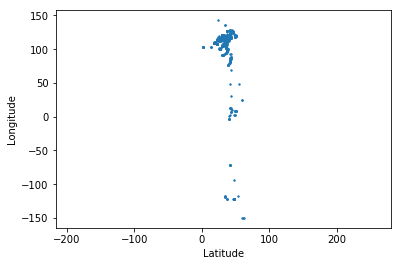

Max: ['61.979938959718048', '142.879521474999990'] degrees
Min: ['1.289692389966555', '-150.013873258347473'] degrees
Mean: ['39.648763665307506', '115.290101256728761'] degrees
Median: ['39.976483585105079', '116.337387332238023'] degrees
Standard Deviation: ['2.228369429440340', '14.663587280843670'] degrees


In [26]:
plt.scatter(meanPoss[:,0],meanPoss[:,1],s=2)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.axis('equal')
plt.show()

print('Max:', ['%.15f' % val for val in np.max(meanPoss, axis=0)],'degrees')
print('Min:', ['%.15f' % val for val in np.min(meanPoss, axis=0)],'degrees')
print('Mean:', ['%.15f' % val for val in np.mean(meanPoss, axis=0)],'degrees')
print('Median:', ['%.15f' % val for val in np.median(meanPoss, axis=0)],'degrees')
print('Standard Deviation:', ['%.15f' % val for val in np.std(meanPoss, axis=0)],'degrees')

Could possibly use the median of the mean positions as an origin when converting the coordinates into metres. The position of the origin is arbitrary but this would aid in keeping most of the distances easily readable. I will use the Haversine function to convert the latitude/longitude to metres accurately:

In [ ]:
def haversine(startPos, endPos, radius):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """

    lon1, lat1, lon2, lat2 = map(np.radians, [startPos[1], startPos[0], endPos[1], endPos[0]])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = radius * c
    return distance

Will use an ellipsoid model of the Earth to calculate the radius:

In [8]:
def earthRad(Lat):
	'''
	Calculates the Earth's radius (in m) at a given latitude using an ellipsoidal model. Major/minor axes from NASA

	'''
	a = 6378137
	b = 6356752
	Lat = np.radians(Lat)
	g = (a**2*np.cos(Lat))**2 + (b**2*np.sin(Lat))**2
	f = (a*np.cos(Lat))**2 + (b*np.sin(Lat))**2
	R = np.sqrt(g/f)
	return R

As previously suggested, I will use the median of the mean positions as the origin for the series. This may change once I filter more outliers from the data, but I'll use the current value as it won't make any difference to subsequent analysis:

In [29]:
print('Origin:', ['%.15f' % val for val in np.median(meanPoss, axis=0)],'degrees')

Origin: ['39.976483585105079', '116.337387332238023'] degrees
